In [1]:
import pandas as pd
import pickle
from datasets import Dataset
import torch
from datasets import DatasetDict
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix
from transformers import TrainingArguments, Trainer


In [2]:
label_encoding = {
    0: "Deliberation",
    1: "Imaginative entry",
    2: "Other",
    3: "Procedure",
    4: "Seminar",
    5: "Social",
    6: "UX",
}

In [5]:

# Load data
train_df = pd.read_pickle("train_dataset")
test_df = pd.read_pickle("test_dataset")
val_df = pd.read_pickle("val_dataset")

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df),
    'val': Dataset.from_pandas(val_df)
})


In [6]:
# Load model
PATH = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PATH, local_files_only=False)
model = BertForSequenceClassification.from_pretrained(PATH, local_files_only=False, num_labels=7)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [7]:
# define preprocess function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_data = dataset.map(preprocess_function, batched=True, batch_size=100,  load_from_cache_file=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

training_args = TrainingArguments(
    output_dir="./bert_runs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()
trainer.train()

Map:   0%|          | 0/427 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

C:\Users\Ana\Desktop\local playground NLP\nlp\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.108384,0.663043
2,No log,1.044474,0.652174
3,No log,1.027884,0.695652
4,No log,1.000829,0.739130
5,0.866400,0.994277,0.739130


TrainOutput(global_step=535, training_loss=0.844640396688586, metrics={'train_runtime': 144.0207, 'train_samples_per_second': 14.824, 'train_steps_per_second': 3.715, 'total_flos': 62926964296950.0, 'train_loss': 0.844640396688586, 'epoch': 5.0})

In [8]:
model.to('cpu')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Bert base test misspredictions

In [9]:
# Get wrong predictions, also return the text, true label and predicted label
def get_wrong_predictions(model, tokenizer, test_data, test_label):
    model.eval()
    predictions = []
    for i in range(len(test_data)):
        text = test_data[i]
        label = test_label[i]
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions.append(np.argmax(logits))
    wrong_predictions = []
    test_labels = []
    preds = []
    for i in range(len(predictions)):
        if predictions[i] != test_label[i]:
            wrong_predictions.append(test_data[i])
            test_labels.append(test_label[i])
            preds.append(predictions[i])
    return wrong_predictions, test_labels, preds



# Add test dataset
test_data = dataset['test']['text']
test_label = dataset['test']['label']

# Add validation dataset
val_data = dataset['val']['text']
val_label = dataset['val']['label']

# Join test and val data
data = test_data + val_data
labels = test_label + val_label

wrong_predictions, labels, preds = get_wrong_predictions(model, tokenizer, data, labels)

# Use label encoding to get the label names
labels_name = [label_encoding[label] for label in labels]
preds_name = [label_encoding[pred.item()] for pred in preds]



In [10]:
print(f"Length of all data: {len(dataset['val']) + len(dataset['test']) + len(dataset['train'])}, wrong predictions in test and validation dataset: {len(wrong_predictions)}")

Length of all data: 611, wrong predictions in test and validation dataset: 56


In [11]:
for text_pred, label, pred in zip(wrong_predictions, labels_name, preds_name):
    if len(text_pred) > 20:
        continue
        
    
    print(f"Text: {text_pred}")
    print(f"True label: {label}")
    print(f"Predicted label: {pred}")
    print("\n")



Text: Who knows? 
True label: Seminar
Predicted label: Deliberation


Text: w
True label: Seminar
Predicted label: Social


Text: I like it
True label: Deliberation
Predicted label: Seminar


Text: Submitted
True label: Deliberation
Predicted label: Procedure


Text: att
True label: Seminar
Predicted label: Social


Text: w
True label: Other
Predicted label: Social


Text: And that's true! 
True label: Imaginative entry
Predicted label: Seminar


Text: Good idea.
True label: Seminar
Predicted label: Social


Text: I am on,
True label: Procedure
Predicted label: Social


Text: I couldn't either.
True label: Procedure
Predicted label: Seminar


Text: I'm in google chrome
True label: UX
Predicted label: Procedure


Text: acce
True label: Seminar
Predicted label: Deliberation


Text: it's wonderful!
True label: Seminar
Predicted label: Social


Text: ok
True label: Deliberation
Predicted label: Social


Text: ooooh
True label: UX
Predicted label: Social




C:\Users\Ana\Desktop\local playground NLP\nlp\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


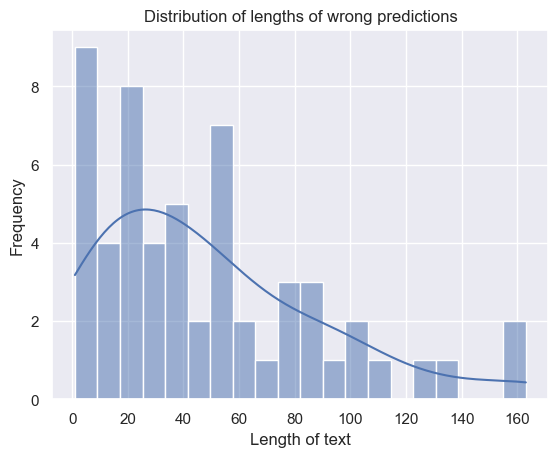

In [13]:
# Plot distribution of lengths of wrong predictions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
lengths = [len(text) for text in wrong_predictions]
sns.histplot(lengths, kde=True, bins=20)
plt.title("Distribution of lengths of wrong predictions")

# Add xticts based on bin width
bin_width = 20
plt.xticks(np.arange(0, max(lengths), bin_width))


plt.xlabel("Length of text")
plt.ylabel("Frequency")

# Save plot
plt.savefig("../images/wrong_predictions_length_distribution.pdf")


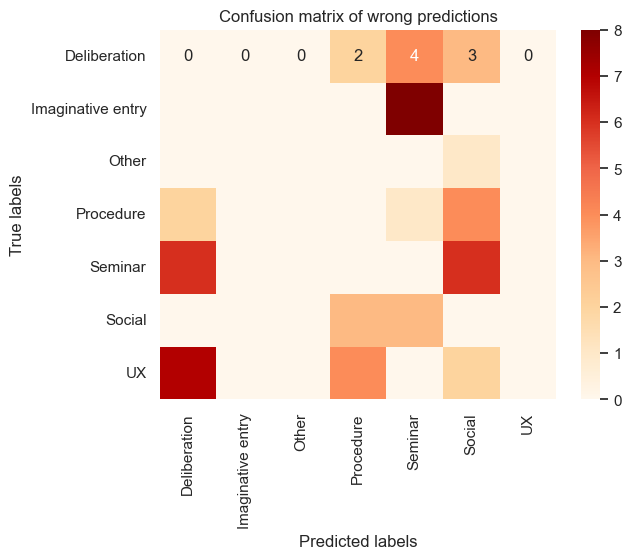

In [14]:
# Construct confusion matrix
cm = confusion_matrix(labels_name, preds_name, labels=list(label_encoding.values()))

sns.heatmap(cm, annot=True, xticklabels=list(label_encoding.values()), yticklabels=list(label_encoding.values()), cmap='OrRd')
# Change xticts to be vertical
# Show cell text in other colors
plt.rcParams['text.color'] = 'red'

# Add predicted and expected labels
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix of wrong predictions")

# Save plot
plt.savefig("../images/confusion_matrix_wrong_predictions.pdf")